In [1]:
import os
import glob
from IPython.display import clear_output

import time
from time import sleep
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from utils.MovingAverager import *
from collections import defaultdict

In [2]:
validation_traj = np.load(f'./training_traj_0.6.npy')
training_traj = np.load(f'./all_user_match_data.npy', allow_pickle=True)

In [3]:
train_data = training_traj.item()
pose_set = set()
for user_name in train_data.keys():
    for path_name in train_data[user_name].keys():
        for posture_name in train_data[user_name][path_name].keys():
            pose_set.add(posture_name)
print(pose_set)

{'front_pocket', 'horizontal', 'swing', 'pocket', 'target'}


In [4]:
posture_data = defaultdict(list)
train_data = training_traj.item()
for user_name in train_data.keys():
    for path_name in train_data[user_name].keys():
        for posture_name in train_data[user_name][path_name].keys():
            data = train_data[user_name][path_name][posture_name]
            pos = (data[:, [0, 1]] + np.array((1, 1))) * 0.6
            imu = data[:, [3, 4, 5, 6, 7, 8, 9, 10, 11]]
            mag = data[:, [12, 13, 14, 15]]

            pos_mag = np.concatenate((pos, imu, mag), axis=-1)
            posture_data[posture_name].append(pos_mag)

In [5]:
posture_data.keys()

dict_keys(['front_pocket', 'horizontal', 'pocket', 'swing', 'target'])

In [6]:
def split_traj(trajs, length=20):
    sp_traj = []
    for traj in trajs:
        for i in range(len(traj) - length + 1):
            sp_traj.append(traj[i:i+length])
    return np.array(sp_traj)

In [7]:
prep_training_traj = split_traj(posture_data['horizontal'])
prep_valid_traj = split_traj(validation_traj)

prep_training_traj.shape, prep_valid_traj.shape

((674, 20, 15), (310, 20, 6))

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

In [9]:
class IMUDataset(Dataset):
    def __init__(self, data, coords_only=False):

        self.data = data
        self.coords_only = coords_only

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.coords_only:
            full_data = self.data[idx]  # [20, 2]
            coords = full_data[:, :2]
            mag = full_data[:, 2:]
            return coords, mag
        else:
            full_data = self.data[idx]  # [20, 11]
            coords = full_data[:, :2]  # 提取前兩列為座標
            imu_data = full_data[:, 2:11]  # 提取剩下的作為IMU數據
            mag = full_data[:, 11:]
            return coords, imu_data, mag


train_data = [torch.from_numpy(sample).float() for sample in prep_training_traj]
impl_data = [torch.from_numpy(sample).float() for sample in prep_valid_traj]

# 創建數據集對象
train_dataset = IMUDataset(train_data)
impl_dataset = IMUDataset(impl_data, coords_only=True)

# 創建DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
impl_loader = DataLoader(impl_dataset, batch_size=32, shuffle=False)

In [10]:
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.lstm1 = nn.LSTM(input_size=32, hidden_size=128, batch_first=True)  # 条件维度2
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, batch_first=True)  # 条件维度2
        self.fc = nn.Linear(256, 9)  # 输出维度为9，每个序列元素
        self.batchnorm = nn.BatchNorm1d(256)

    def forward(self, noise, conditions):
        combined_input = torch.cat([noise, conditions], dim=2)  # 合并噪声和条件
        output, _ = self.lstm1(combined_input)
        output, _ = self.lstm2(output)
        output = self.batchnorm(output.transpose(1, 2)).transpose(1, 2)
        return self.fc(output)  # 输出batch_size * sequence_length * 9

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.lstm = nn.LSTM(input_size=9 + 2, hidden_size=64, batch_first=True)  # 数据维度9，条件维度2
        self.fc = nn.Linear(64, 1)  # 输出一个实值

    def forward(self, imu_data, conditions):
        # imu_data形状应为batch_size * sequence_length * 9
        # conditions形状应为batch_size * sequence_length * 2
        combined_input = torch.cat([imu_data, conditions], dim=2)
        output, _ = self.lstm(combined_input)
        output = self.fc(output[:, -1, :])  # 可能需要使用序列的最后一个输出
        return output

In [12]:
def critic_loss(critic, real_data, fake_data, conditions):
    real_scores = critic(real_data, conditions)
    fake_scores = critic(fake_data, conditions)
    return fake_scores.mean() - real_scores.mean()

def generator_loss(critic, fake_data, conditions):
    fake_scores = critic(fake_data, conditions)
    return -fake_scores.mean()

def compute_gradient_penalty(critic, real_data, fake_data, conditions, device):
    # 梯度惩罚应该在真实数据和生成数据之间的插值上计算
    alpha = torch.rand(real_data.size(0), 1, 1, device=device).expand_as(real_data)
    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = interpolates.requires_grad_(True)  # 需要计算关于插值的梯度
    interpolates_conditions = conditions.requires_grad_(True)  # 条件也需计算梯度
    
    # 计算鉴别器在插值数据上的输出
    d_interpolates = critic(interpolates, interpolates_conditions)
    
    # 为了计算梯度，需要一个同形状的全1张量
    fake = torch.ones(d_interpolates.size(), device=device, requires_grad=False)
    
    # 计算插值的输出相对于插值本身的梯度
    gradients = torch.autograd.grad(outputs=d_interpolates,
                                    inputs=[interpolates, interpolates_conditions],
                                    grad_outputs=fake,
                                    create_graph=True,
                                    retain_graph=True,
                                    only_inputs=True)[0]
    # 调整梯度形状，并计算梯度的L2范数和1的偏差平方，即梯度惩罚项
    gradients = gradients.reshape(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty

In [13]:
losses_G = []
losses_D = []

generator_losses = []
critic_losses = []

def evaluate_generator(generator, discriminator, data_loader):
    generator.eval()
    discriminator.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for coords, _ in data_loader:
            coords = coords.to(device)
            fake_imu_data = generator(coords)
            outputs = discriminator(fake_imu_data).view(-1)
            predicted = outputs.round()  # 假设阈值为0.5
            total += coords.size(0)
            correct += (predicted == 0).sum().item()  # 假设假数据标签为0
    return 100 * correct / total

def evaluate_on_impl(generator, critic, impl_data_loader, device):
    critic.eval()  # 将模型设置为评估模式
    total_loss = 0
    with torch.no_grad():  # 不计算梯度
        for (coords, _) in impl_data_loader:
            conditions = coords.to(device)
            noise = torch.zeros(conditions.size(0), conditions.size(1), 30, device=device)
            fake_data = generator(noise, conditions)
            scores = critic(fake_data, conditions)
            loss = -scores.mean()  # 可以根据具体情况定义损失计算方式
            total_loss += loss.item()
    critic.train()  # 将模型恢复到训练模式
    return total_loss / len(impl_data_loader)

In [14]:
def plot_losses(generator_losses, critic_losses, impl_losses, epoch):
    plt.figure(figsize=(15, 20))
    plt.subplot(4, 1, 1)
    plt.title("Training Losses")
    plt.plot(generator_losses, label="Generator Loss")
    plt.plot(critic_losses, label="Critic Loss")
    plt.xlabel("Epoch Number")
    plt.ylabel("Loss")
    plt.xlim(max(0, epoch - 100), epoch)
    plt.ylim(-30, 30)
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.title("Training Losses")
    plt.plot(generator_losses, label="Generator Loss")
    plt.plot(critic_losses, label="Critic Loss")
    plt.xlabel("Epoch Number")
    plt.ylabel("Loss")
    plt.ylim(-30, 30)
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.title("Implementation Dataset Loss")
    plt.plot(impl_losses, label="Impl Dataset Loss")
    plt.xlabel("Epoch Number")
    plt.ylabel("Loss")
    plt.xlim(max(0, epoch - 100), epoch)
    plt.ylim(-30, 30)
    plt.legend()
    
    plt.subplot(4, 1, 4)
    plt.title("Implementation Dataset Loss")
    plt.plot(impl_losses, label="Impl Dataset Loss")
    plt.xlabel("Epoch Number")
    plt.ylabel("Loss")
    plt.ylim(-30, 30)
    plt.legend()
    plt.show()

Epoch:  10000, D_loss: -2.471, G_loss: -25.630, Impl_loss: -7.014


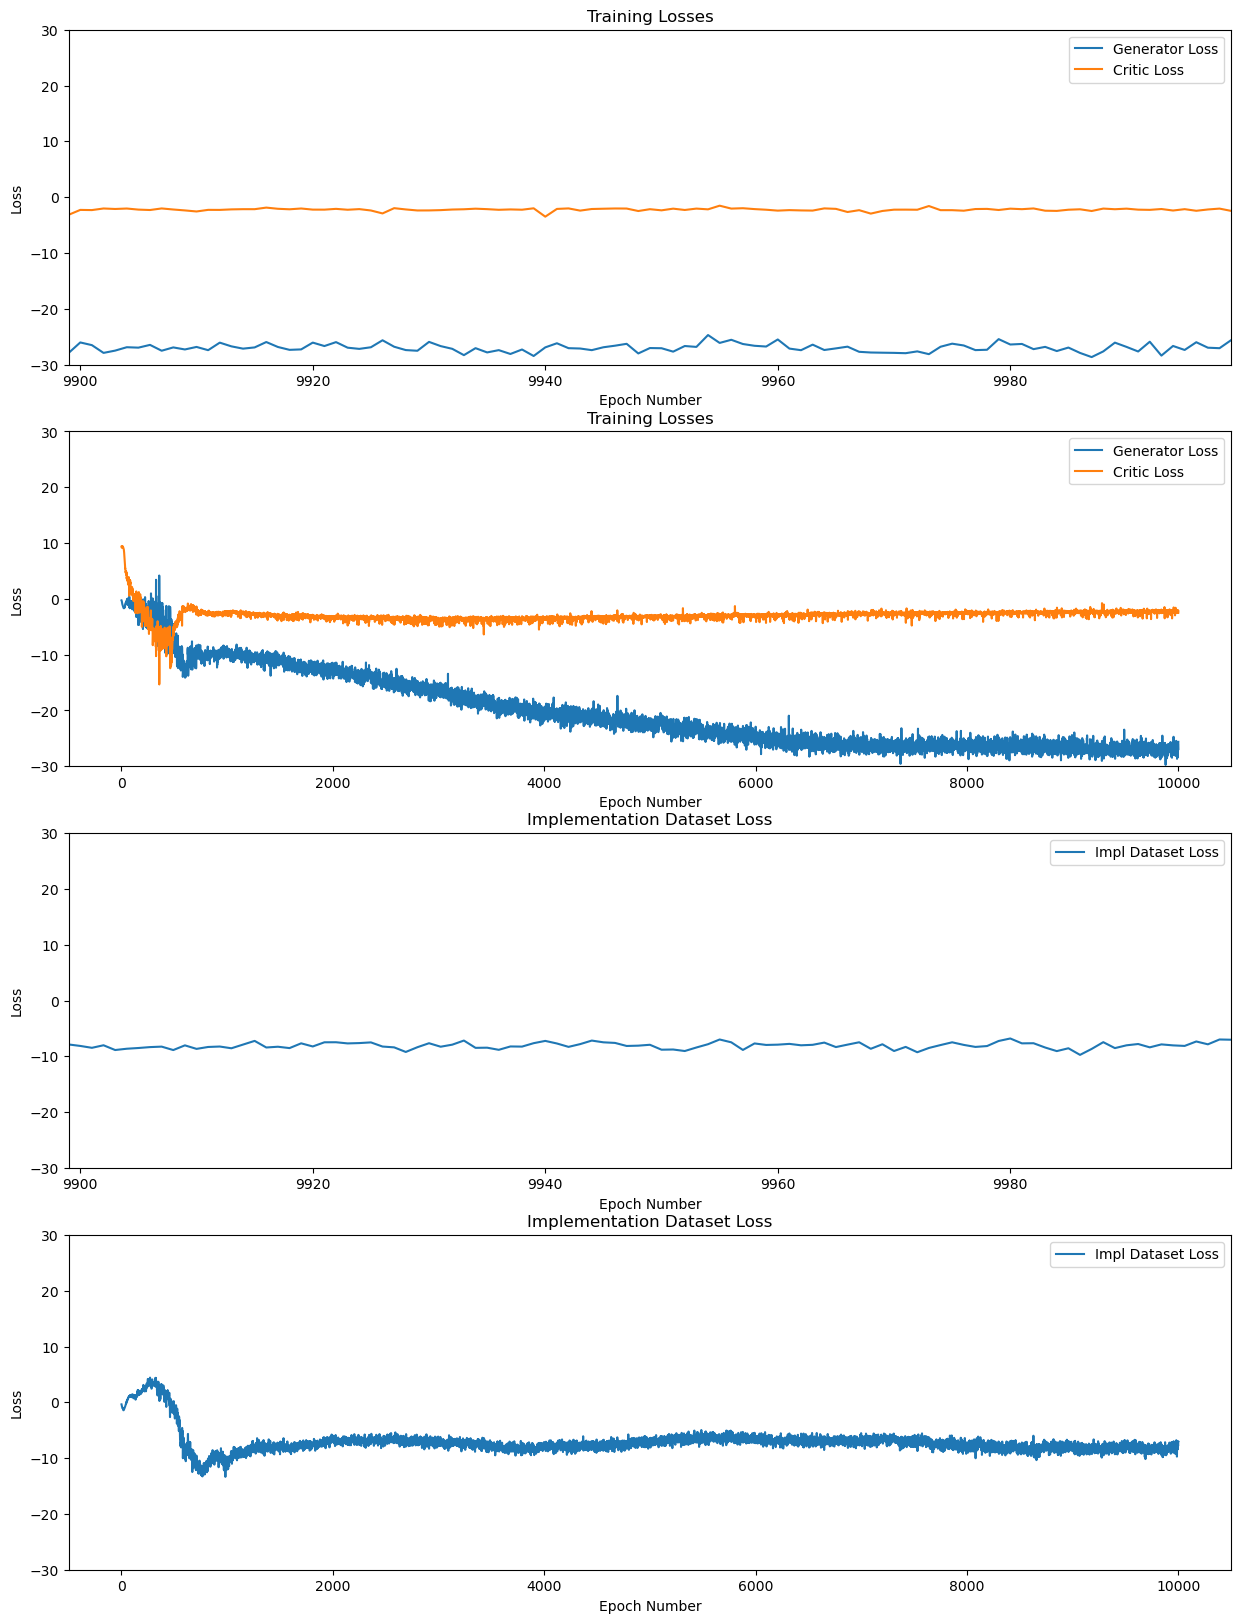

In [15]:
# 设置优化器
# 损失函数
criterion = nn.BCELoss()
accuracy = []
# 训练参数

# 训练过程
num_epochs = 10000
update_interval = 10  # 日志和图表更新的频率

generator = Generator().to(device)
critic = Critic().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.9))
optimizer_C = optim.Adam(critic.parameters(), lr=0.00005, betas=(0.5, 0.9))

lambda_gp = 10  # 梯度惩罚系数
n_critic = 5  # 鉴别器更新次数

critic_losses, generator_losses, impl_losses = [], [], []

for epoch in range(num_epochs):
    d_losses, g_losses = [], []
    for i, (coords, real_imu_data, _) in enumerate(train_loader):
        real_data = real_imu_data.to(device)
        conditions = coords.to(device)
        noise = torch.randn(real_data.size(0), real_data.size(1), 30, device=device)

        # 使用CuDNN优化除非需要计算梯度惩罚
        with torch.backends.cudnn.flags(enabled=False), torch.set_grad_enabled(True):
            fake_data = generator(noise, conditions)
            critic.zero_grad()
            real_scores = critic(real_data, conditions)
            fake_scores = critic(fake_data.detach(), conditions)
            d_loss = fake_scores.mean() - real_scores.mean()
            gp = compute_gradient_penalty(critic, real_data, fake_data, conditions, device)
            d_loss_total = d_loss + lambda_gp * gp
            d_loss_total.backward()
            optimizer_C.step()

        d_losses.append(d_loss_total.item())

        # 更新生成器
        if i % n_critic == 0:
            generator.zero_grad()
            fake_data = generator(noise, conditions)
            fake_scores = critic(fake_data, conditions)
            g_loss = -fake_scores.mean()
            g_loss.backward()
            optimizer_G.step()
            g_losses.append(g_loss.item())

    # 计算实现数据集上的损失
    impl_loss = evaluate_on_impl(generator, critic, impl_loader, device)
    impl_losses.append(impl_loss)
    critic_losses.append(np.mean(d_losses))
    generator_losses.append(np.mean(g_losses))
    
    
    # 日志打印和图表更新
    if (epoch + 1) % update_interval == 0:
        clear_output(wait=True)
        print(f"Epoch: {epoch + 1:>6d}, D_loss: {np.mean(d_losses):>6.3f}, G_loss: {np.mean(g_losses):>6.3f}, Impl_loss: {impl_loss:>6.3f}")
        plot_losses(generator_losses, critic_losses, impl_losses, epoch)

In [16]:
torch.save(generator, 'generator.pt')

In [ ]:
from random import sample
def plot_acc():
    
    sample_train = sample(range(len(train_dataset)))
    sample_impl  = sample(range(len(impl_dataset)))
    plt.figure(figsize=(15, 20))
    
    for i in sample_train:
    
        plt.title("ith sequence")
        plt.plot(generator_losses, label="Generator Loss")
        plt.plot(critic_losses, label="Critic Loss")
        plt.xlabel("Epoch Number")
        plt.ylabel("Loss")
        plt.xlim(max(0, epoch - 100), epoch)
        plt.ylim(-30, 30)
        plt.legend()

    plt.subplot(2, 1, 2)
    plt.title("Training Losses")
    plt.plot(generator_losses, label="Generator Loss")
    plt.plot(critic_losses, label="Critic Loss")
    plt.xlabel("Epoch Number")
    plt.ylabel("Loss")
    plt.ylim(-30, 30)
    plt.legend()
    